# Brain Tumor MRI Classification

**Multi-class classification**: glioma, meningioma, pituitary, no tumor

This notebook includes:
- Kaggle dataset integration
- EfficientNet-V2-S transfer learning
- Mixed precision training
- Model export ready for server deployment (Fly.io)

---

## 1. Setup & GPU Check

In [1]:
# Check GPU availability
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device('cpu')
    print("No GPU found. Go to Runtime > Change runtime type > GPU")

print(f"\nUsing device: {device}")

GPU Available: Tesla T4
   Memory: 15.8 GB

Using device: cuda


## 2. Kaggle Setup

You'll need your Kaggle API credentials. Get them from:
1. Go to kaggle.com → Your Profile → Settings
2. Scroll to "API" section → Click "Create New Token"
3. This downloads `kaggle.json`

In [2]:
# Install Kaggle API
!pip install -q kaggle

In [3]:
# Upload your kaggle.json file
from google.colab import files
import os

# Create .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

print("Upload your kaggle.json file:")
uploaded = files.upload()

# Move to correct location
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
print("\nKaggle credentials configured!")

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle credentials configured!


In [4]:
# Download the brain tumor dataset
# Dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip -p ./data

print("\nDataset downloaded!")

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
  0% 0.00/149M [00:00<?, ?B/s]
100% 149M/149M [00:00<00:00, 1.57GB/s]

📂 Dataset downloaded!


In [5]:
# Verify dataset structure
import os

DATA_ROOT = './data'

# Find the actual data directories
for root, dirs, files in os.walk(DATA_ROOT):
    level = root.replace(DATA_ROOT, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:  # Only show 2 levels deep
        for d in dirs:
            print(f"{indent}  📁 {d}")

data/
  📁 Testing
  📁 Training
  Testing/
    📁 pituitary
    📁 meningioma
    📁 glioma
    📁 notumor
    pituitary/
    meningioma/
    glioma/
    notumor/
  Training/
    📁 pituitary
    📁 meningioma
    📁 glioma
    📁 notumor
    pituitary/
    meningioma/
    glioma/
    notumor/


In [6]:
# Set paths (adjust if your structure differs)
TRAIN_PATH = './data/Training'
TEST_PATH = './data/Testing'

# Count images per class
print("📊 Dataset Statistics:\n")
print("Training Set:")
train_total = 0
for class_name in sorted(os.listdir(TRAIN_PATH)):
    class_path = os.path.join(TRAIN_PATH, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        train_total += count
        print(f"  {class_name}: {count} images")
print(f"  Total: {train_total}\n")

print("Testing Set:")
test_total = 0
for class_name in sorted(os.listdir(TEST_PATH)):
    class_path = os.path.join(TEST_PATH, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        test_total += count
        print(f"  {class_name}: {count} images")
print(f"  Total: {test_total}")

📊 Dataset Statistics:

Training Set:
  glioma: 1321 images
  meningioma: 1339 images
  notumor: 1595 images
  pituitary: 1457 images
  Total: 5712

Testing Set:
  glioma: 300 images
  meningioma: 306 images
  notumor: 405 images
  pituitary: 300 images
  Total: 1311


## 3. Import Libraries

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cu126


## 4. Data Preprocessing & Augmentation

In [8]:
# Image transforms
# Training: augmentation to prevent overfitting
# Validation/Test: clean transforms for honest evaluation

IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✅ Transforms defined")

✅ Transforms defined


In [9]:
# Load datasets
train_dataset_full = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=val_transform)

# Split training into train/validation (85/15)
train_size = int(0.85 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply validation transform to val split
# (Note: This is a workaround since random_split shares the parent transform)
val_dataset_clean = datasets.ImageFolder(root=TRAIN_PATH, transform=val_transform)
val_indices = val_dataset.indices
val_dataset = torch.utils.data.Subset(val_dataset_clean, val_indices)

# Class names and count
class_names = train_dataset_full.classes
num_classes = len(class_names)

print(f"\nFinal Split:")
print(f"   Training:   {len(train_dataset)} images")
print(f"   Validation: {len(val_dataset)} images")
print(f"   Testing:    {len(test_dataset)} images")
print(f"\nClasses ({num_classes}): {class_names}")


📊 Final Split:
   Training:   4855 images
   Validation: 857 images
   Testing:    1311 images

🏷️ Classes (4): ['glioma', 'meningioma', 'notumor', 'pituitary']


In [10]:
# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoaders created (batch_size={BATCH_SIZE})")

✅ DataLoaders created (batch_size=32)


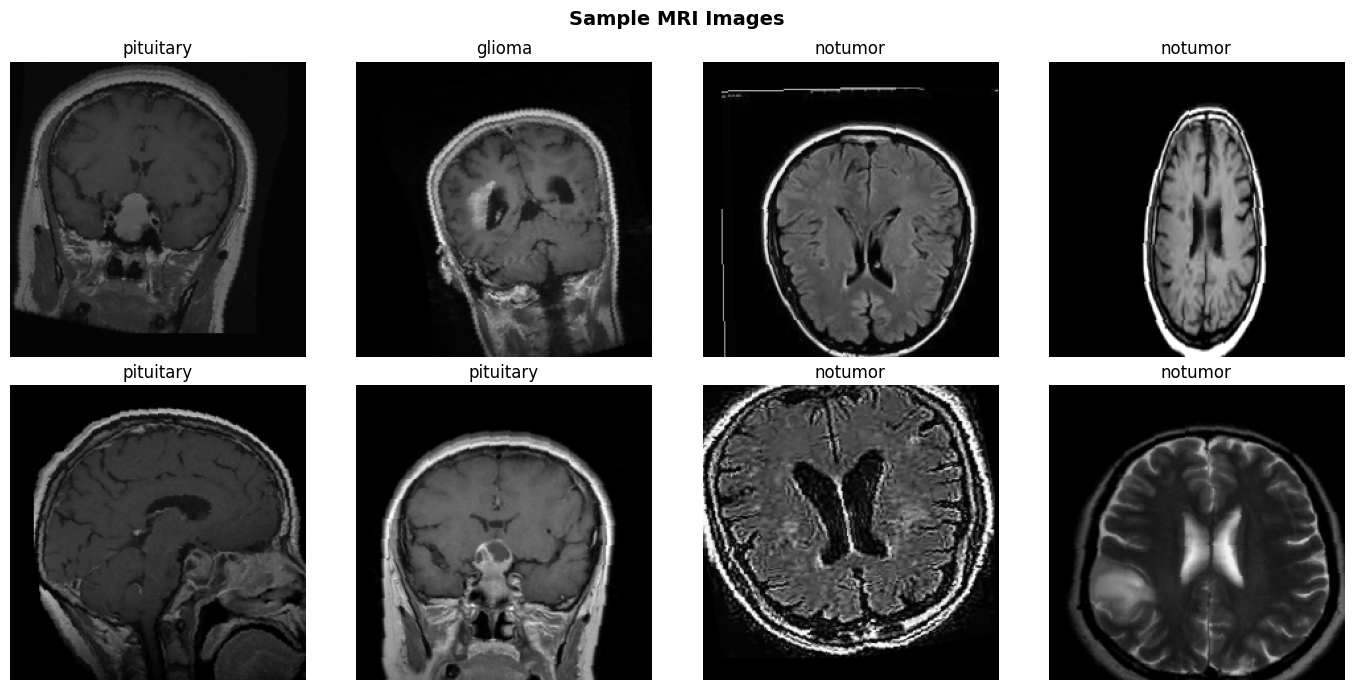

In [11]:
# Visualize sample images
def show_samples(dataset, class_names, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))

    # Denormalization values
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    indices = np.random.choice(len(dataset), n, replace=False)

    for idx, ax in zip(indices, axes.flat):
        img, label = dataset[idx]
        img = img * std + mean  # Denormalize
        img = img.permute(1, 2, 0).numpy().clip(0, 1)

        ax.imshow(img)
        ax.set_title(class_names[label], fontsize=12)
        ax.axis('off')

    plt.suptitle('Sample MRI Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_samples(train_dataset_full, class_names)

## 5. Model Architecture

In [12]:
def build_model(num_classes, dropout=0.3):
    """
    EfficientNet-V2-S with custom classifier head.
    Pretrained on ImageNet, fine-tuned for brain tumor classification.
    """
    # Load pretrained model
    model = models.efficientnet_v2_s(weights='DEFAULT')

    # Freeze early layers (optional - can unfreeze for fine-tuning)
    for param in model.features[:5].parameters():
        param.requires_grad = False

    # Replace classifier head
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout/2),
        nn.Linear(512, num_classes)
    )

    return model.to(device)

model = build_model(num_classes)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: EfficientNet-V2-S")
print(f"   Total parameters:     {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Output classes:       {num_classes}")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:01<00:00, 77.2MB/s]


📐 Model: EfficientNet-V2-S
   Total parameters:     20,835,412
   Trainable parameters: 19,013,836
   Output classes:       4


## 6. Training Configuration

In [14]:
# Loss function with label smoothing (prevents overconfidence)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

# Learning rate scheduler (verbose removed in PyTorch 2.x)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

# Mixed precision scaler (faster training on GPU)
scaler = GradScaler('cuda')

print("Training configuration set")

Training configuration set


## 7. Training Loop

In [15]:
def train_epoch(model, loader, criterion, optimizer, scaler):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass with scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.1f}%'})

    return running_loss / total, 100 * correct / total


def validate(model, loader, criterion):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, 100 * correct / total

In [16]:
# Training loop
NUM_EPOCHS = 15
best_val_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("Starting Training...\n")
print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Train Acc':^10} | {'Val Loss':^12} | {'Val Acc':^10} | {'LR':^10}")
print("-" * 75)

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        marker = ' ⭐'
    else:
        marker = ''

    print(f"{epoch+1:^7} | {train_loss:^12.4f} | {train_acc:^10.2f}% | {val_loss:^12.4f} | {val_acc:^10.2f}% | {current_lr:^10.6f}{marker}")

print("\n" + "=" * 75)
print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")

🚀 Starting Training...

 Epoch  |  Train Loss  | Train Acc  |   Val Loss   |  Val Acc   |     LR    
---------------------------------------------------------------------------


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   1    |    0.6065    |   87.77   % |    0.4561    |   95.22   % |  0.001000  ⭐


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   2    |    0.4761    |   94.25   % |    0.4131    |   97.20   % |  0.001000  ⭐


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   3    |    0.4309    |   96.29   % |    0.3968    |   97.90   % |  0.001000  ⭐


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   4    |    0.4134    |   97.30   % |    0.4337    |   95.80   % |  0.001000 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   5    |    0.4085    |   97.53   % |    0.4055    |   96.62   % |  0.001000 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   6    |    0.3995    |   98.02   % |    0.4131    |   97.20   % |  0.000500 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   7    |    0.3807    |   98.83   % |    0.3784    |   98.48   % |  0.000500  ⭐


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   8    |    0.3701    |   99.16   % |    0.3720    |   99.18   % |  0.000500  ⭐


Training:   0%|          | 0/152 [00:00<?, ?it/s]

   9    |    0.3686    |   99.32   % |    0.3683    |   98.83   % |  0.000500 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

  10    |    0.3592    |   99.69   % |    0.3743    |   99.18   % |  0.000500 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

  11    |    0.3680    |   99.26   % |    0.4267    |   97.32   % |  0.000500 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

  12    |    0.3667    |   99.32   % |    0.3720    |   98.95   % |  0.000250 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

  13    |    0.3626    |   99.55   % |    0.3892    |   98.48   % |  0.000250 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

  14    |    0.3588    |   99.63   % |    0.3737    |   98.83   % |  0.000250 


Training:   0%|          | 0/152 [00:00<?, ?it/s]

  15    |    0.3588    |   99.63   % |    0.3718    |   99.07   % |  0.000125 

✅ Training complete! Best validation accuracy: 99.18%


## 8. Training Visualization

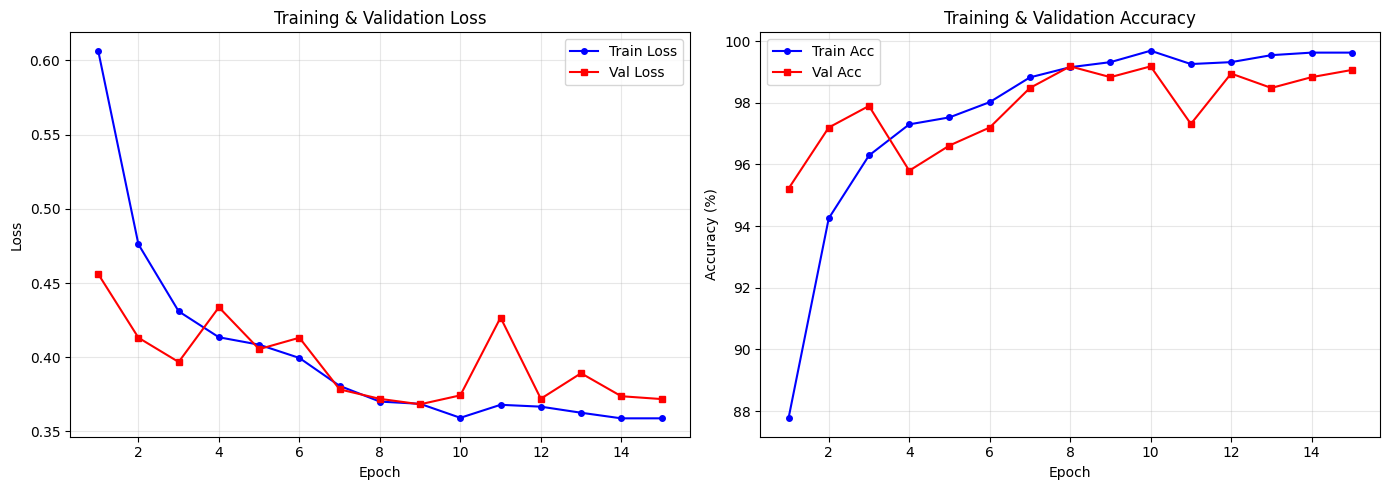

In [17]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Loss plot
axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', markersize=4)
axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', markersize=4)
axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

## 9. Evaluation on Test Set

In [19]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Set Results:")
print(f"   Loss:     {test_loss:.4f}")
print(f"   Accuracy: {test_acc:.2f}%")

Test Set Results:
   Loss:     0.3746
   Accuracy: 98.86%


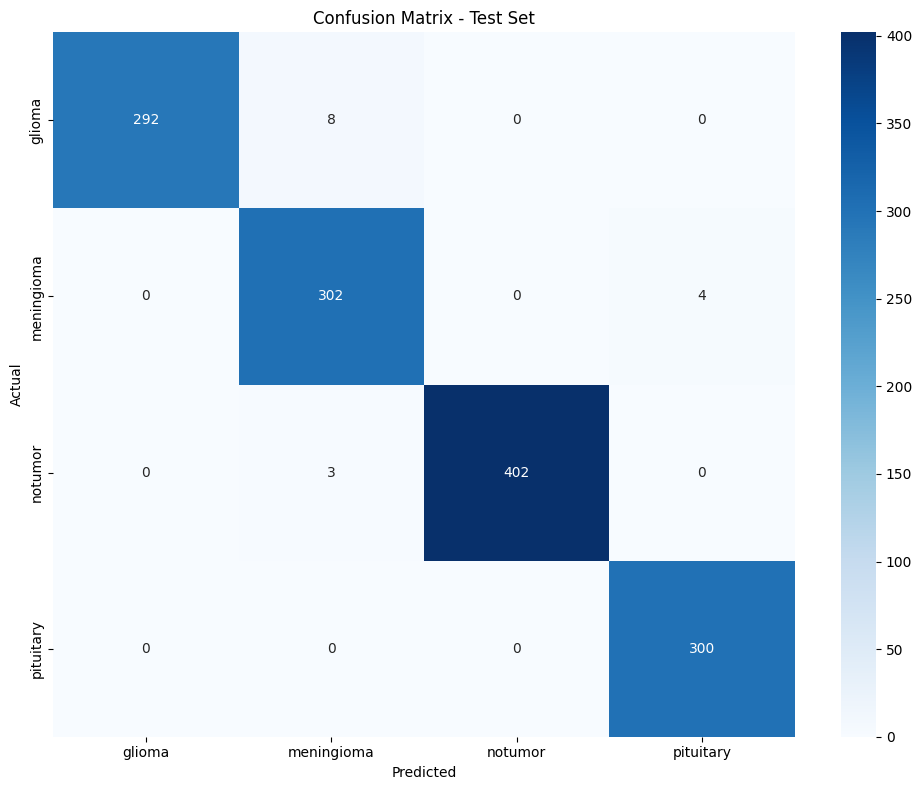


Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.97      0.99       300
  meningioma       0.96      0.99      0.98       306
     notumor       1.00      0.99      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [21]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        with autocast('cuda'):
            outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

## 10. Save Model for Deployment


In [22]:
# Create deployment directory
import os
os.makedirs('deployment', exist_ok=True)

# Save model weights
torch.save(model.state_dict(), 'deployment/brain_tumor_model.pth')

# Save class names and config
config = {
    'class_names': class_names,
    'num_classes': num_classes,
    'image_size': IMG_SIZE,
    'model_architecture': 'efficientnet_v2_s',
    'normalization': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    },
    'test_accuracy': test_acc,
    'training_epochs': NUM_EPOCHS
}

with open('deployment/model_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Model saved for deployment")
print(f"\nFiles in deployment/:")
for f in os.listdir('deployment'):
    size = os.path.getsize(f'deployment/{f}') / 1e6
    print(f"   {f}: {size:.2f} MB")

✅ Model saved for deployment!

📁 Files in deployment/:
   model_config.json: 0.00 MB
   brain_tumor_model.pth: 84.25 MB


In [23]:
# Create inference script for deployment
inference_code = '''
"""Brain Tumor Classification - Inference Module
Ready for Fly.io deployment with FastAPI
"""
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import json
import io

class BrainTumorClassifier:
    def __init__(self, model_path='brain_tumor_model.pth', config_path='model_config.json'):
        # Load config
        with open(config_path, 'r') as f:
            self.config = json.load(f)

        self.class_names = self.config['class_names']
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Build model
        self.model = self._build_model()
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()

        # Transforms
        self.transform = transforms.Compose([
            transforms.Resize((self.config['image_size'], self.config['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize(
                self.config['normalization']['mean'],
                self.config['normalization']['std']
            )
        ])

    def _build_model(self):
        model = models.efficientnet_v2_s(weights=None)
        num_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(512, self.config['num_classes'])
        )
        return model.to(self.device)

    def predict(self, image_bytes):
        """Predict tumor type from image bytes."""
        # Load and preprocess image
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # Inference
        with torch.no_grad():
            outputs = self.model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = probabilities.max(1)

        return {
            'prediction': self.class_names[predicted.item()],
            'confidence': float(confidence.item()),
            'probabilities': {
                name: float(prob)
                for name, prob in zip(self.class_names, probabilities[0].tolist())
            }
        }
'''

with open('deployment/classifier.py', 'w') as f:
    f.write(inference_code)

print("✅ Inference module created!")

✅ Inference module created!


In [24]:
# Download deployment files
from google.colab import files
import shutil

# Zip deployment folder
shutil.make_archive('brain_tumor_deployment', 'zip', 'deployment')

print("Downloading deployment package...")
files.download('brain_tumor_deployment.zip')

📥 Downloading deployment package...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 11. Quick Inference Test

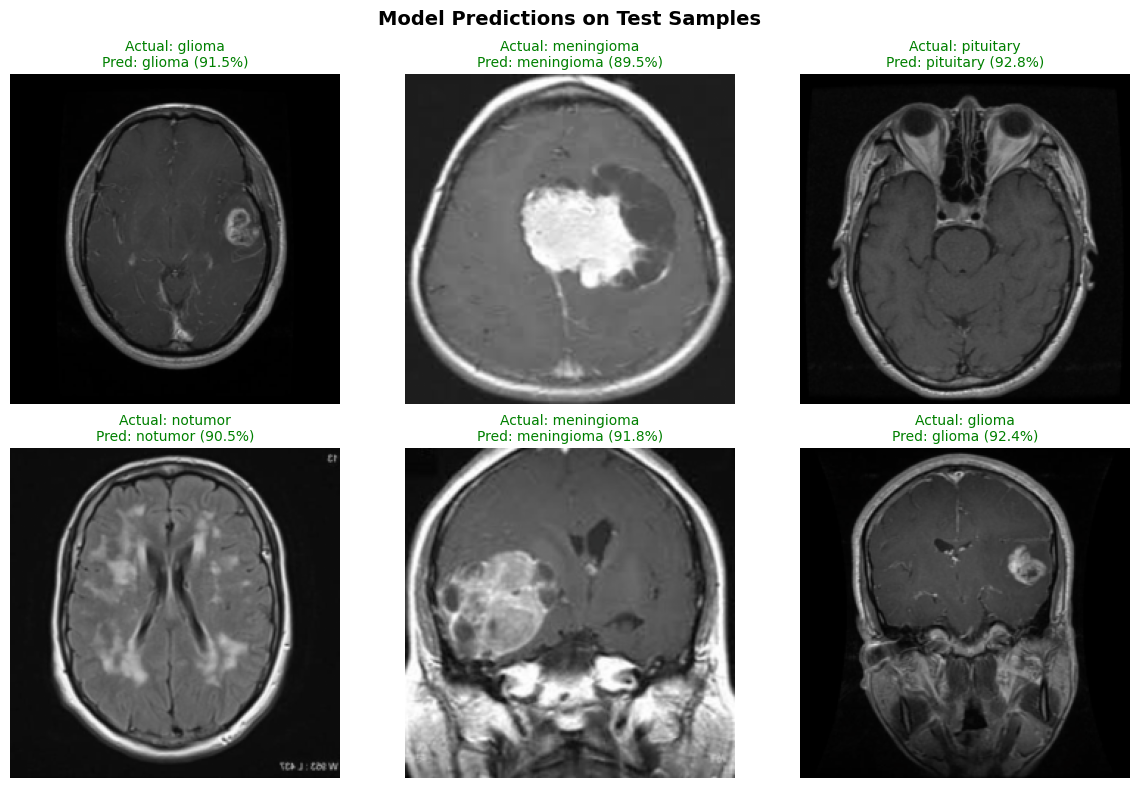

In [25]:
# Test inference on a few samples
def predict_and_show(model, dataset, class_names, n=6):
    """Show predictions on random samples."""
    model.eval()
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    indices = np.random.choice(len(dataset), n, replace=False)

    for idx, ax in zip(indices, axes.flat):
        img, label = dataset[idx]

        # Predict
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))
            probs = torch.softmax(output, dim=1)
            conf, pred = probs.max(1)

        # Display
        img_display = (img * std + mean).permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img_display)

        actual = class_names[label]
        predicted = class_names[pred.item()]
        confidence = conf.item() * 100

        color = 'green' if actual == predicted else 'red'
        ax.set_title(f'Actual: {actual}\nPred: {predicted} ({confidence:.1f}%)',
                    color=color, fontsize=10)
        ax.axis('off')

    plt.suptitle('Model Predictions on Test Samples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

predict_and_show(model, test_dataset, class_names)

## 12. Grad-CAM Visualization

Visualize which regions of the MRI the model focuses on when making predictions.

In [26]:
import torch.nn.functional as F
import cv2

class GradCAM:
    """Grad-CAM implementation for model visualization."""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        """Generate Grad-CAM heatmap."""
        self.model.eval()

        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Generate heatmap
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, target_class

print("Grad-CAM class defined")

Grad-CAM class defined


🔍 Generating Grad-CAM visualizations...



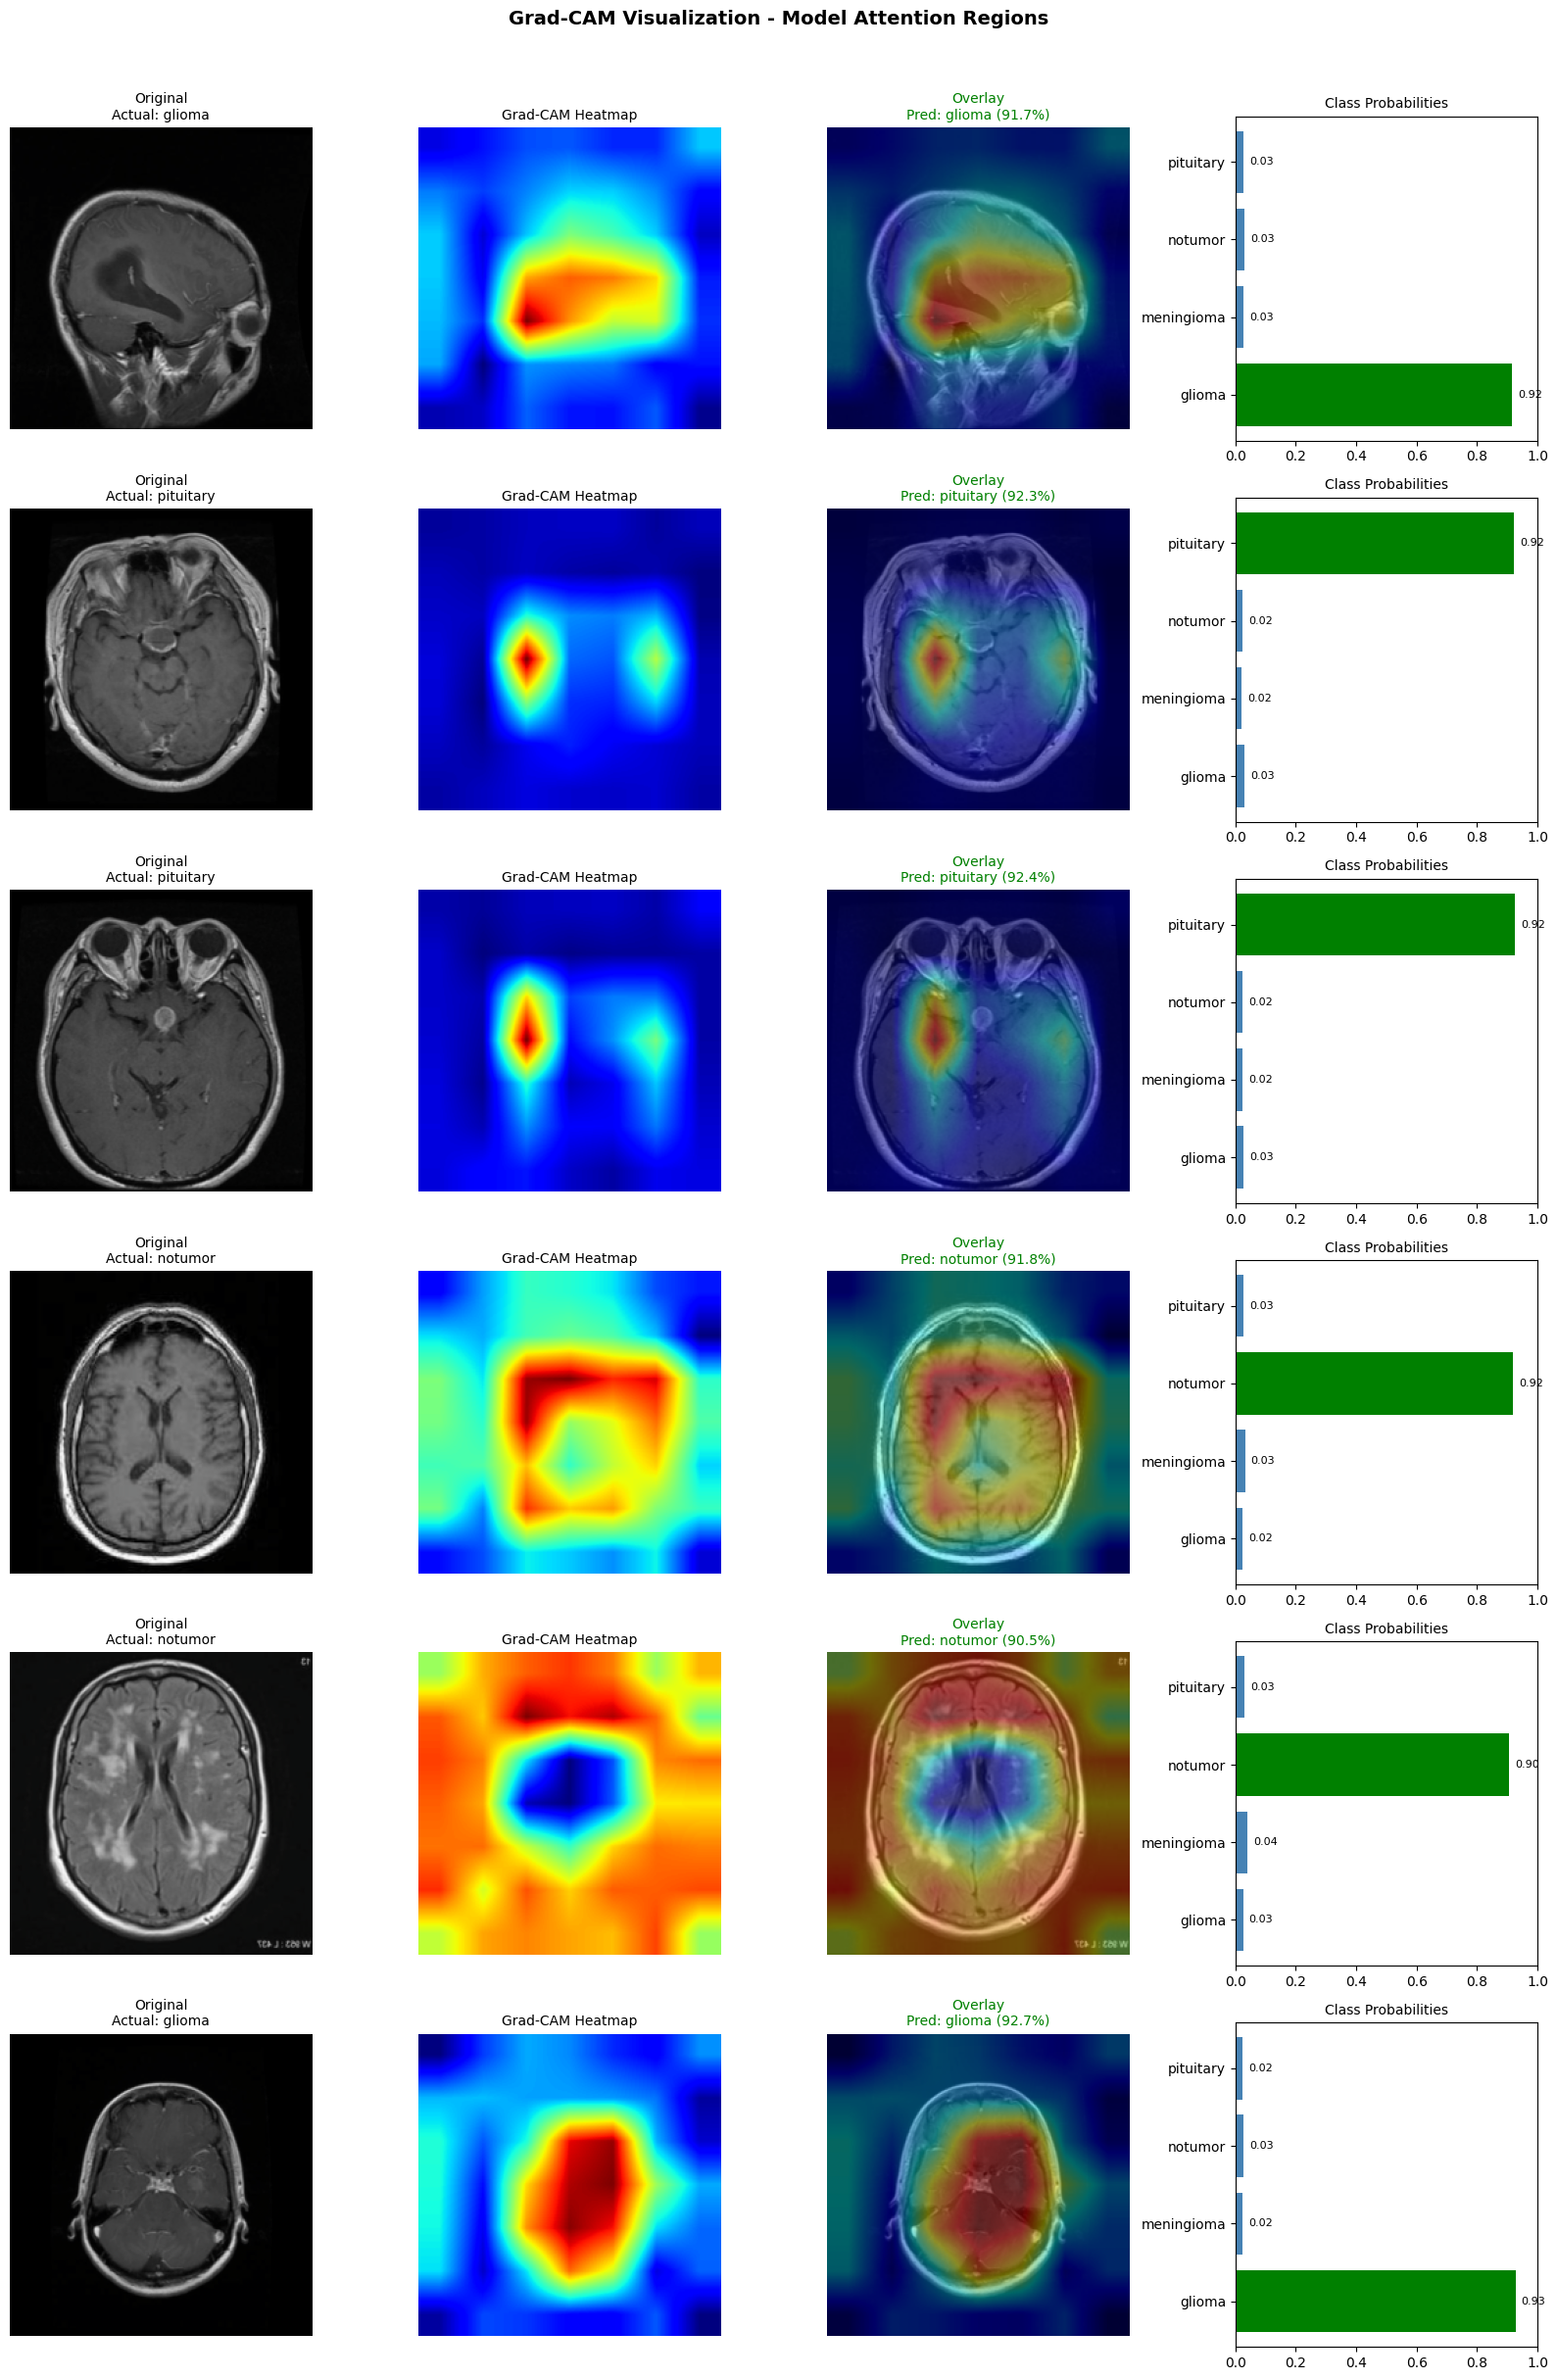

In [27]:
def visualize_gradcam(model, dataset, class_names, num_samples=8):
    """
    Generate Grad-CAM visualizations for random samples.
    Shows: Original | Heatmap | Overlay
    """
    # Setup Grad-CAM with last convolutional layer
    target_layer = model.features[-1]
    gradcam = GradCAM(model, target_layer)

    # Denormalization values
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    for i, idx in enumerate(indices):
        img_tensor, label = dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad_(True)

        # Get prediction
        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1)
            conf, pred = probs.max(1)

        # Generate Grad-CAM (need gradients, so no torch.no_grad)
        input_tensor.requires_grad_(True)
        heatmap, _ = gradcam.generate(input_tensor, pred.item())

        # Denormalize original image
        original = img_tensor.cpu().numpy().transpose(1, 2, 0)
        original = (original * std + mean).clip(0, 1)
        original_uint8 = (original * 255).astype(np.uint8)

        # Resize heatmap to image size
        heatmap_resized = cv2.resize(heatmap, (224, 224))

        # Apply colormap
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8),
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Create overlay
        overlay = (0.6 * original_uint8 + 0.4 * heatmap_colored).astype(np.uint8)

        # Plot
        actual = class_names[label]
        predicted = class_names[pred.item()]
        confidence = conf.item() * 100
        is_correct = actual == predicted

        # Original
        axes[i, 0].imshow(original)
        axes[i, 0].set_title(f'Original\nActual: {actual}', fontsize=10)
        axes[i, 0].axis('off')

        # Heatmap
        axes[i, 1].imshow(heatmap_resized, cmap='jet')
        axes[i, 1].set_title('Grad-CAM Heatmap', fontsize=10)
        axes[i, 1].axis('off')

        # Overlay
        axes[i, 2].imshow(overlay)
        color = 'green' if is_correct else 'red'
        axes[i, 2].set_title(f'Overlay\nPred: {predicted} ({confidence:.1f}%)',
                            fontsize=10, color=color)
        axes[i, 2].axis('off')

        # Probability bar chart
        probs_np = probs[0].cpu().numpy()
        colors = ['green' if j == pred.item() else 'steelblue' for j in range(len(class_names))]
        axes[i, 3].barh(class_names, probs_np, color=colors)
        axes[i, 3].set_xlim(0, 1)
        axes[i, 3].set_title('Class Probabilities', fontsize=10)
        for j, v in enumerate(probs_np):
            axes[i, 3].text(v + 0.02, j, f'{v:.2f}', va='center', fontsize=8)

    plt.suptitle('Grad-CAM Visualization - Model Attention Regions',
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('gradcam_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

# Run visualization
print("Generating Grad-CAM visualizations...\n")
visualize_gradcam(model, test_dataset, class_names, num_samples=6)

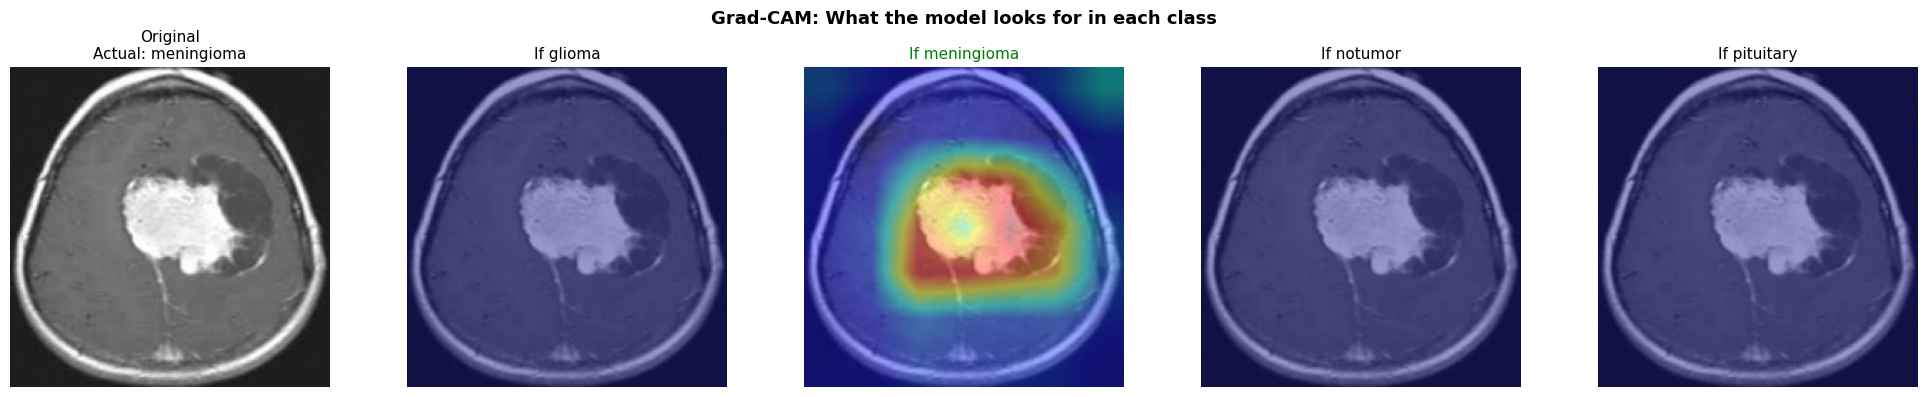

In [28]:
def visualize_class_comparison(model, dataset, class_names, target_idx=0):
    """
    Show Grad-CAM for all classes on a single image.
    Useful for understanding what features distinguish each class.
    """
    target_layer = model.features[-1]
    gradcam = GradCAM(model, target_layer)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Get a sample
    img_tensor, label = dataset[target_idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    # Denormalize original
    original = img_tensor.cpu().numpy().transpose(1, 2, 0)
    original = (original * std + mean).clip(0, 1)
    original_uint8 = (original * 255).astype(np.uint8)

    fig, axes = plt.subplots(1, len(class_names) + 1, figsize=(4 * (len(class_names) + 1), 4))

    # Original
    axes[0].imshow(original)
    axes[0].set_title(f'Original\nActual: {class_names[label]}', fontsize=11)
    axes[0].axis('off')

    # Grad-CAM for each class
    for i, class_name in enumerate(class_names):
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad_(True)

        heatmap, _ = gradcam.generate(input_tensor, target_class=i)
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8),
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        overlay = (0.6 * original_uint8 + 0.4 * heatmap_colored).astype(np.uint8)

        axes[i + 1].imshow(overlay)
        title_color = 'green' if i == label else 'black'
        axes[i + 1].set_title(f'If {class_name}', fontsize=11, color=title_color)
        axes[i + 1].axis('off')

    plt.suptitle('Grad-CAM: What the model looks for in each class',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show class comparison for a random sample
random_idx = np.random.randint(0, len(test_dataset))
visualize_class_comparison(model, test_dataset, class_names, target_idx=random_idx)

In [29]:
# Download Grad-CAM visualization
from google.colab import files
files.download('gradcam_visualization.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>